# Using CRF To Refine The Segmentation Maps

## Load Testing Dataset

In [1]:
import glob
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array

images = np.array([img_to_array(load_img(img_file, color_mode='rgb')) for img_file in glob.glob('demo/predict/rgb*.png')])
labels = np.array([img_to_array(load_img(img_file, color_mode='grayscale')) for img_file in glob.glob('demo/predict/label*.png')])

images = images.astype('uint8')
labels = np.reshape(labels, labels.shape[:-1]).astype('uint8')

## Define The Model

In [2]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels

# Fully connected CRF post processing function
def do_crf(im, mask, zero_unsure=True):
    colors, labels = np.unique(mask, return_inverse=True)
    image_size = mask.shape[:2]
    n_labels = len(set(labels.flat))
    d = dcrf.DenseCRF2D(image_size[1], image_size[0], n_labels)  # width, height, nlabels
    U = unary_from_labels(labels, n_labels, gt_prob=.7, zero_unsure=zero_unsure)
    d.setUnaryEnergy(U)
    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3,3), compat=3)
    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    # im is an image-array, e.g. im.dtype == np.uint8 and im.shape == (640,480,3)
    d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=im.astype('uint8'), compat=10)
    Q = d.inference(5) # 5 - num of iterations
    MAP = np.argmax(Q, axis=0).reshape(image_size)
    unique_map = np.unique(MAP)
    for u in unique_map: # get original labels back
        np.putmask(MAP, MAP == u, colors[u])
    return MAP
    # MAP = do_crf(frame, labels.astype('int32'), zero_unsure=False)

## Refine The Predictions

In [15]:
from time import time
start = time()
refined_labels = [do_crf(img, label, zero_unsure=False) for img, label in zip(images, labels)]
duration = time() - start
print('Totally refined %d samples, average %.2fs per sample' % (len(refined_labels), duration/len(refined_labels)))

Totally refined 9 samples, average 0.44s per sample


## Evaluate The Performance

In [8]:
from matplotlib import pyplot as plt


def plot_samples(images, labels, refined_labels):
    """Function to plot the results"""
    num_samples = len(labels)

    fig, ax = plt.subplots(num_samples, 3, figsize=(10, 15))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)    
    
    for i in range(num_samples):
        ax[i, 0].imshow(images[i])    
        ax[i, 0].axis('off')
        if i == 0: ax[i, 0].set_title('Raw Input')

        ax[i, 1].imshow(labels[i], cmap='gray')     
        ax[i, 1].axis('off')
        if i == 0: ax[i, 1].set_title('UNET')

        ax[i, 2].imshow(refined_labels[i], cmap='gray')     
        ax[i, 2].axis('off')
        if i == 0: ax[i, 2].set_title('UNET + CRF')

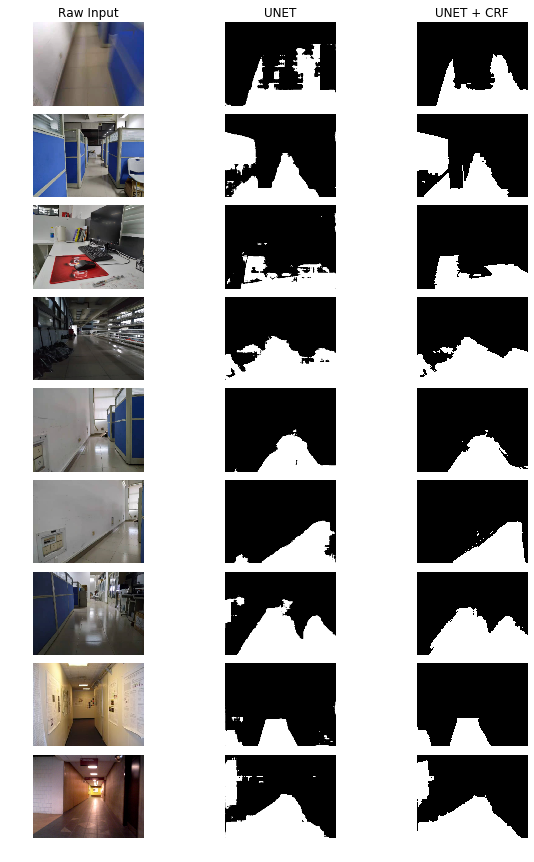

In [9]:
plot_samples(images, labels, refined_labels)

In [11]:
from tensorflow.keras.preprocessing.image import save_img
from tqdm import tqdm_notebook
from pathlib import Path
import numpy as np
import os

OUTPUT_PATH = Path('demo/finetune')
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)

for index, (image, label) in enumerate((tqdm_notebook(zip(images, refined_labels), total=len(images), desc="Saving images and labels"))):
    image_fname = OUTPUT_PATH / ('rgb_%04d.png' % index)
    label_fname = OUTPUT_PATH / ('label_%04d.png' % index)

    save_img(image_fname, image, scale=True)
    
    label = np.expand_dims(label, -1)
    save_img(label_fname, label, scale=True)